xvector_dvector_inspection 
------------------------

왜 xvector는 PDLA에서 엄청나게 좋은 성능을 내는가?

다른 논문에서는 xvector+LDA/PLDA가 엄청나게 좋은 성능을 보이지 않는데.. 혹시 augmentation 효과가 큰건가?

일단 dvector와 무엇이 다른지 emprical하게 알아보고자 한다.

- input_frame에 따른 성능변화의 차이?
- lda이후에 xvector와 dvector가 어떻게 변하나?
- centering과 length normalization 이후의 변화는?


### Environment

In [38]:
%load_ext autoreload
%autoreload 2
# %pylab
%matplotlib inline
plt.ioff()
    
import pandas as pd
import pickle
import numpy as np
import sys
import os
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
sys.path.append('/host/projects/sv_experiments/')
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [5]:
def key2df(keys, delimeter="-"):
    key_df = pd.DataFrame(keys, columns=['key'])
    key_df['spk'] = key_df.key.apply(lambda x: x.split(delimeter)[0])
    key_df['label'] = key_df.groupby('spk').ngroup()
    key_df['origin'] = key_df.spk.apply(lambda x: 'voxc2' if x.startswith('id') else 'voxc1')
    
    return key_df

In [49]:
from MulticoreTSNE import MulticoreTSNE as TSNE
import matplotlib.cm as cm

def run_tsne(sv_key_df, sv_embeds, title):
    sv_all_spks = sv_key_df.spk.unique().tolist()

    tsne_size = 40
    tsne_spks = np.random.choice(sv_all_spks, size=tsne_size, replace=False)
    spk2label = {k:i for i, k in enumerate(tsne_spks)}

    tsne_df = sv_key_df[sv_key_df.spk.isin(tsne_spks)]
    tsne_embeds = sv_embeds[tsne_df.index]

    X_embedded = TSNE(n_components=2).fit_transform(tsne_embeds)

    colors = cm.rainbow_r(np.linspace(0, 1, tsne_size))
    c_label = tsne_df.spk.apply(lambda x: tsne_spks.tolist().index(x))

    fig = plt.figure(figsize=(10,10))
    for spk in tsne_spks:
        X = X_embedded[tsne_df[tsne_df.spk == spk].index]
        plt.scatter(X[:,0], X[:,1], c=colors[tsne_spks.tolist().index(spk)] )
    plt.legend(['s{}'.format(i) for i in range(len(tsne_spks))], loc=2, bbox_to_anchor=(1.05, 1), borderaxespad=0., fontsize=11)
    plt.title(title)
    
    return fig

## TSNE

### Kaldi voxc12 x-vector 

In [113]:
# si_keys = pickle.load(open("../../embeddings/voxc12/xvectors/xvectors_tdnn6b/train_feat/key.pkl", "rb"))
# si_embeds = np.load("../../embeddings/voxc12/xvectors/xvectors_tdnn6b/train_feat/feat.npy")

sv_keys = pickle.load(open("../../embeddings/voxc12/xvectors/xvectors_tdnn6b/test_feat/key.pkl", "rb"))
sv_embeds = np.load("../../embeddings/voxc12/xvectors/xvectors_tdnn6b/test_feat/feat.npy")
sv_key_df = key2df(sv_keys)

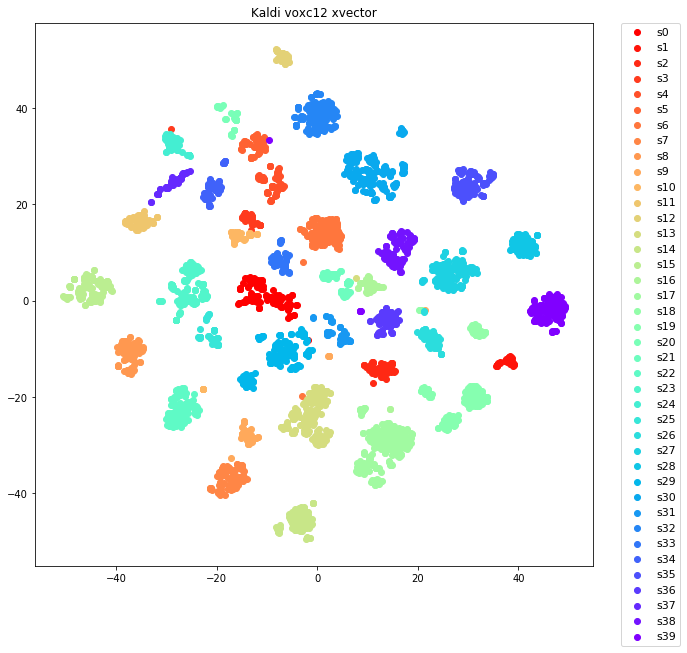

In [114]:
fig = run_tsne(sv_key_df, sv_embeds, "Kaldi voxc12 xvector")

### Kaldi voxc12 x-vector LDA

In [115]:
import kaldi_io

sv_keys = []
sv_embeds = []
for k,v in kaldi_io.read_vec_flt_ark("../../embeddings/voxc12/xvectors/xvectors_tdnn6b/lda_test/lda_feats.ark"):
    sv_keys += [k]
    sv_embeds += [v]

sv_embeds = np.array(sv_embeds)

In [116]:
# si_key_df = key2df(si_keys)
sv_key_df = key2df(sv_keys)

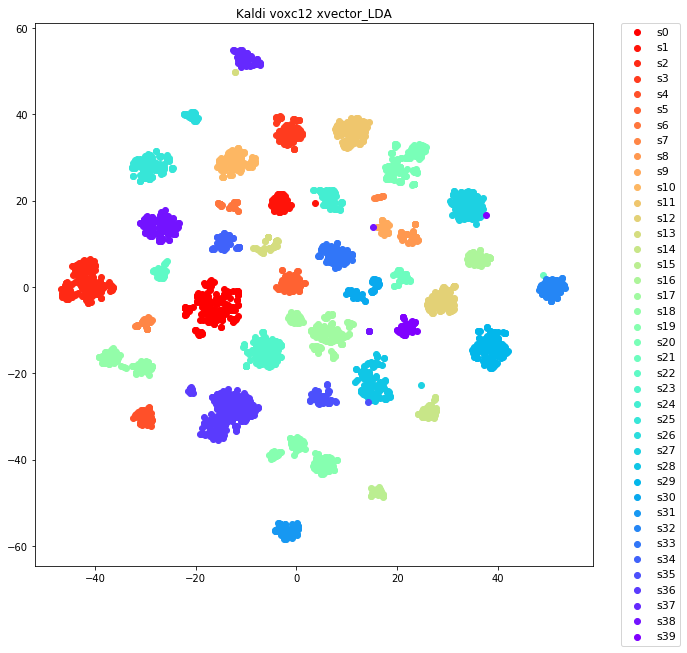

In [117]:
fig = run_tsne(sv_key_df, sv_embeds, "Kaldi voxc12 xvector_LDA")

### Pytorch voxc12 x-vector

이건 fbank_xvector로 트레이닝 한다음 fbank로 뽑은 것이라

정확한 결과는 아니다.

In [59]:
sv_keys = pickle.load(open("../../models/voxc12_fbank_xvector/tdnn_xvector_softmax/fbank64_200f_400f_v01/embedding/sv_keys.pkl", "rb"))
sv_embeds = np.load("../../models/voxc12_fbank_xvector/tdnn_xvector_softmax/fbank64_200f_400f_v01/embedding/sv_embeds.npy")

In [60]:
sv_key_df = key2df(sv_keys, delimeter='-')

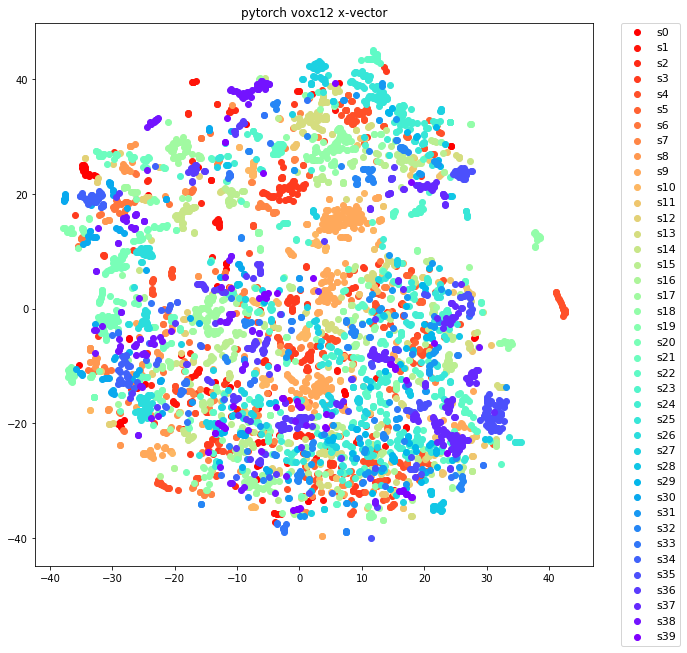

In [61]:
fig = run_tsne(sv_key_df, sv_embeds, "pytorch voxc12 x-vector")

## voxc1 d-vector 

In [118]:
sv_keys = pickle.load(open("../../embeddings/voxc1/dvectors/ResNet34_v4_softmax/sv_keys.pkl", "rb"))
sv_embeds = np.load("../../embeddings/voxc1/dvectors/ResNet34_v4_softmax/sv_embeds.npy")

In [119]:
# si_key_df = key2df(si_keys, delimeter='/')
sv_key_df = key2df(sv_keys, delimeter='/')

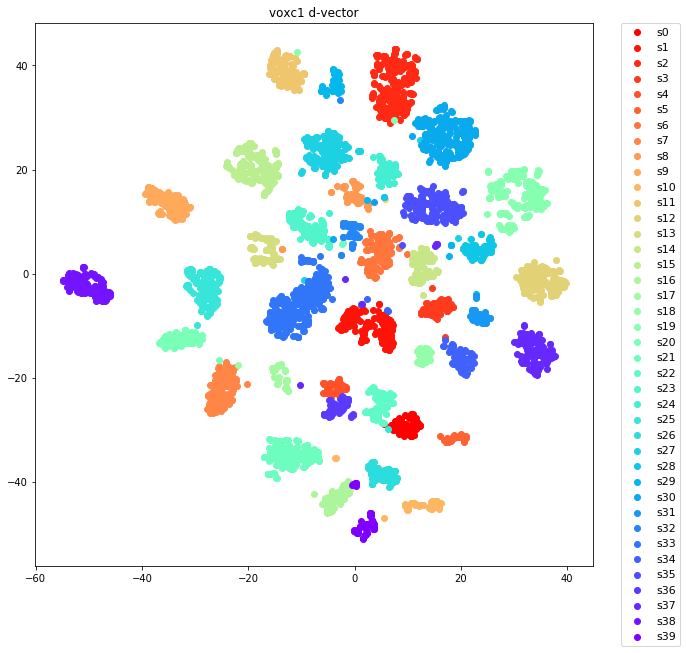

In [120]:
fig = run_tsne(sv_key_df, sv_embeds, "voxc1 d-vector")

## voxc12 d-vector 

In [53]:
sv_keys = pickle.load(open("../../embeddings/voxc12/dvectors/Resnet34_v4_softmax/sv_keys.pkl", "rb"))
sv_embeds = np.load("../../embeddings/voxc12/dvectors/Resnet34_v4_softmax/sv_embeds.npy")

In [57]:
sv_key_df = key2df(sv_keys, delimeter='-')

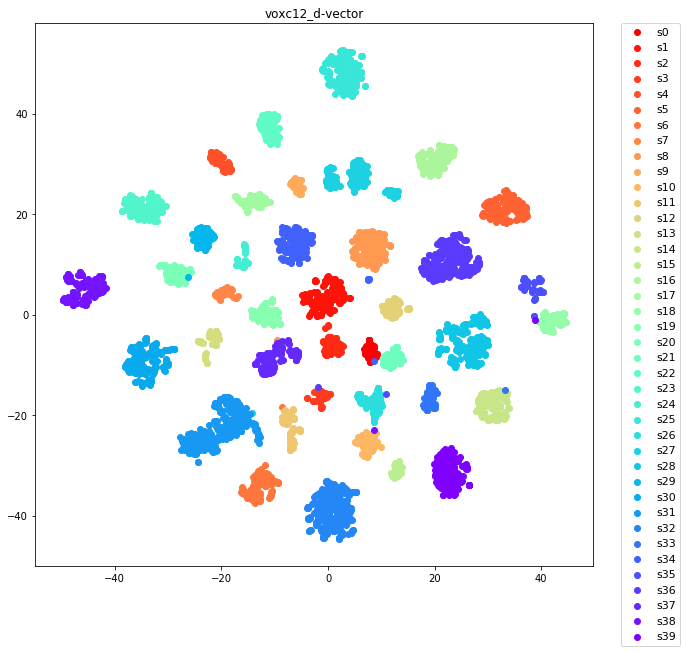

In [58]:
fig = run_tsne(sv_key_df, sv_embeds, "voxc12_d-vector")

## Cosine Similarity

In [67]:
import torch
from torch.nn.functional import cosine_similarity

In [62]:
sv_keys = pickle.load(open("../../embeddings/voxc12/xvectors/xvectors_tdnn6b/test_feat/key.pkl", "rb"))
sv_embeds = np.load("../../embeddings/voxc12/xvectors/xvectors_tdnn6b/test_feat/feat.npy")
sv_key_df = key2df(sv_keys)

In [66]:
embed_tensor = torch.from_numpy(sv_embeds)

In [68]:
cosine_sim_matrix = cosine_similarity(embed_tensor.unsqueeze(1), embed_tensor.unsqueeze(0), dim=2)

In [75]:
label_vec = torch.from_numpy(np.array(sv_key_df.label.tolist()))

In [82]:
label_matrix  = label_vec.unsqueeze(0).expand_as(cosine_sim_matrix)

In [103]:
pos_mask_ = torch.triu(label_matrix == label_matrix.t(), diagonal=1)
neg_mask_ = torch.triu(label_matrix != label_matrix.t(), diagonal=1)

In [104]:
pos_sim_scores = cosine_sim_matrix.masked_select(pos_mask_)

In [105]:
neg_sim_scores = cosine_sim_matrix.masked_select(neg_mask_)

In [109]:
score_vector = pos_sim_scores.numpy().tolist() + neg_sim_scores.numpy().tolist()
label_vector = [1] * len(pos_sim_scores) + [0] * len(neg_sim_scores)

In [110]:
from sklearn.metrics import roc_curve
fpr, tpr, thres = roc_curve(
        label_vector, score_vector, pos_label=1)
eer = fpr[np.nanargmin(np.abs(fpr - (1 - tpr)))]
eer

0.09115011357962068